<a href="https://colab.research.google.com/github/statisticallyfit/PythonNeuralNetNLP/blob/master/src/ModelStudy/TransformerXL/UPDATED_Tutorial_Building_TransformerXLFromScratch_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Blog Source](https://synergo.atlassian.net/wiki/spaces/DataScience/pages/1511359082/Building+the+Transformer+XL+from+Scratch)
$\hspace{1em}$ | $\hspace{1em}$
[Code Source](https://github.com/keitakurita/Practical_NLP_in_PyTorch/blob/master/deep_dives/transformer_xl_from_scratch.ipynb)
# Building the [Transformer XL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716) from Sratch

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.tensor as Tensor
from torch import Size, Tensor
from torch.nn.parameter import Parameter
from torch.nn import Dropout, LayerNorm, Linear, Sequential, ReLU, Embedding, ModuleList, CrossEntropyLoss

import matplotlib.pyplot as plt
import os
from IPython.display import Image

from typing import *


In [0]:
import sys

# Making files in utils folder visible here: to import my local print functions for nn.Module objects
sys.path.append(os.getcwd() + "/src/utils/")
from src.utils.ModelUtil import *

# For being able to import files within TransformerXL folder
sys.path.append(os.getcwd() + '/src/ModelStudy/TransformerXL/') 

In [19]:
# Building pathname for images (from Colab)

# Set current working directory

imagePath = os.getcwd() # now path is the above
print(f"imagePath = {imagePath}\n")
imagePath += "/src/ModelStudy/images/"
print(f"imagePath = {imagePath}")


imagePath = /content/gdrive/My Drive/StatFitScholarshipProject/PythonNeuralNetNLP

imagePath = /content/gdrive/My Drive/StatFitScholarshipProject/PythonNeuralNetNLP/src/ModelStudy/images/


## A Single [Attention Head](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism)
Let us start by implementing a [single attention head](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) in a [`MultiHeadAttention` layer](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1446445463/multi-head+attention+mechanism).
### Assumptions:
* Considering the **first** layer only now
* Receive an input of [word embeddings](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/87666969) of shape `(seq = 7, batchSize = 3, embeddingDim = 32)`
NOTE: the [Transformer XL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716) does not add [positional embeddings](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1470169419) to the input.

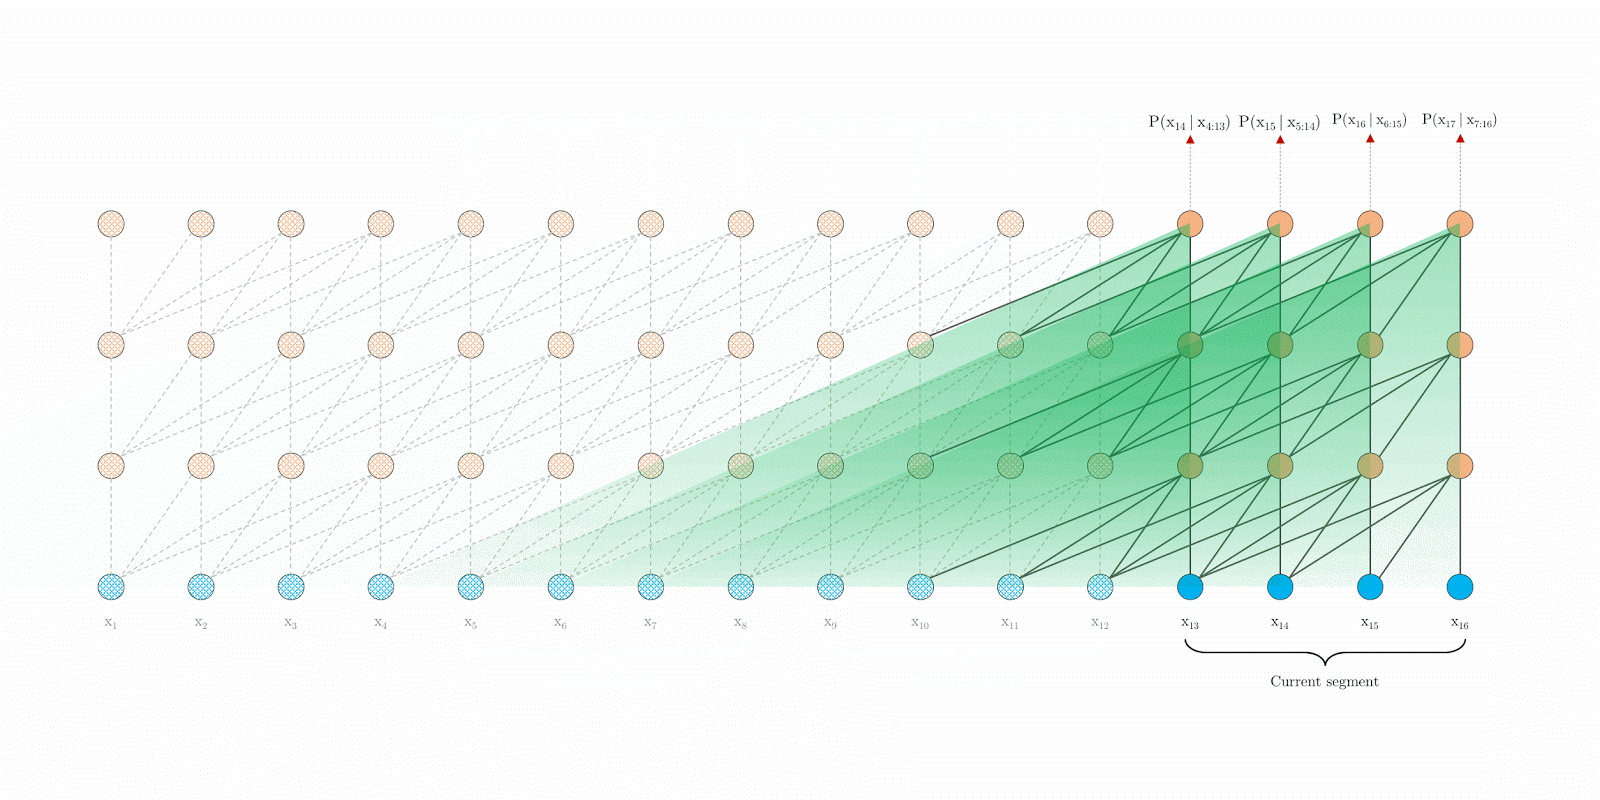

In [20]:
Image(filename =imagePath + "transformerXL_extendedContext.png")

In [0]:
seqSize, batchSize, embeddingDim = 7, 3, 32
# short names
(S, B, E) = (seqSize, batchSize, embeddingDim)

wordEmbeddings: Tensor = torch.rand(seqSize, batchSize, embeddingDim, names = ('sequenceSize', 'batchSize', 'embeddingDim'))

assert wordEmbeddings.names == ('sequenceSize', 'batchSize', 'embeddingDim')

# Method 1 for renaming:
wordEmbeddings.names = ['seqLen', 'batchSize', 'embDim']
assert wordEmbeddings.names == ('seqLen', 'batchSize', 'embDim')

# Method 2 for renaming:
wordEmbeddings: Tensor = wordEmbeddings.rename(seqLen = 'S', batchSize = 'B', embDim = 'E')
assert wordEmbeddings.names == ('S', 'B', 'E')
assert wordEmbeddings.shape == (S, B, E) == (7, 3, 32)
assert wordEmbeddings.ndim == 3

In [0]:
# Gets the first element of wordEmbeddings tensor (first chunk in the seven, along first dimension)
assert wordEmbeddings[0,:,:].ndim == 2
assert wordEmbeddings[0,:,:].shape == (B, E) == (3, 32)

# Indexing along elements along the second dimension, to get elements along the second dimension
assert wordEmbeddings[:,0,:].shape == (S, E) == (7, 32)

# Indexing along the third dimension, to get elements along third dimension
assert wordEmbeddings[:,:,0].shape == (S, B) == (7, 3)

#### Notes about the [Transformer XL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716/transformer-XL+model+ml)
* [Segment-level recurrence mechanism](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1527480493): we feed the cached outputs of the model for the previous sequence (here this means we are feeding the [word embeddings](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/87666969/word+embedding+ml) from the previous sequence as an additional input to our model)
* [Transformer XL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716/transformer-XL+model+ml) does not add the [positional embeddings](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1470169419) to the input, only in the [multi-head attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1446445463/multi-head+attention+mechanism) module.

As an example, let the previous sequence have length $6$, and let [`memory`](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1527480493) denote the hidden states (`Tensor`) from the previous sequence.

In [0]:
prevSeqSize: int = 6
# short name
P: int = prevSeqSize
# These are the hidden states from the previous sequence, as an example
memory: Tensor = torch.rand(prevSeqSize, batchSize, embeddingDim, names = ('P', 'B', 'E'))

assert memory.shape == (P, B, E) == (6, 3, 32)
assert memory.names == ('P', 'B', 'E')

Each [self-attention head](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) takes keys, queries, and values as input. The procedure in the single [attention head](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) is as follows:

1. Apply a separate linear transformation to each of the keys, queries, and values.
2. Compute the [attention scores](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) for each of the values.
3. For each query, compute an [attention-weighted](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) sum of the values.
4. Apply a [residual connection](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1511358877/residual+connection+layer+ml) and [layer normalization](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1450213381/layer+normalization).

### Step 1: Linear Transformation over $Q, K, V$ Matrices

In [0]:

innerDim: int = 17 # this is the internal dimension size
I = innerDim # short form

linearK: Linear = Linear(in_features = embeddingDim, out_features = innerDim)
linearK.weight.names = ('I', 'E')
linearK.bias.names = ('I',)

linearV: Linear = Linear(in_features = embeddingDim, out_features = innerDim)
linearV.weight.names = ('I', 'E')
linearV.bias.names = ('I',)

linearQ: Linear = Linear(in_features = embeddingDim, out_features = innerDim)
linearQ.weight.names = ('I', 'E')
linearQ.bias.names = ('I',)


assert linearK.weight.shape == linearV.weight.shape == linearQ.weight.shape == (I, E)
assert linearK.bias.shape == linearV.bias.shape == linearQ.bias.shape == (I, )

#### Analysis of Linear Layer that Will Create Keys Matrix $K$:

In [25]:
printParamInfo(linearK)

Parameter 0 | Name = weight | Size = [('I', 17), ('E', 32)]
Parameter 1 | Name = bias | Size = [('I', 17)]


In [26]:
getChildInfo(linearK)

Info(Names=[], Types=[], Objects=[])

#### Analysis of Linear Layer that Will Create Values Matrix $V$:

In [27]:
printParamInfo(linearV)

Parameter 0 | Name = weight | Size = [('I', 17), ('E', 32)]
Parameter 1 | Name = bias | Size = [('I', 17)]


In [28]:
getChildInfo(linearV)

Info(Names=[], Types=[], Objects=[])

#### Analysis of Linear Layer that Will Create Query Matrix $Q$:

In [29]:
printParamInfo(linearQ)

Parameter 0 | Name = weight | Size = [('I', 17), ('E', 32)]
Parameter 1 | Name = bias | Size = [('I', 17)]


In [30]:
getChildInfo(linearQ)

Info(Names=[], Types=[], Objects=[])

The [memory (sequence of hidden states)](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1527480493/segment-level+recurrence+mechanism+ml) is concatenated across the sequence dimension and fed as keys / values.

* $\color{orange}{\textbf{WARNING}}$: the memory is not concatenated with the queries, since each query represents one word we want to predict, so it wouldn't make sense to modify the number of queries.

In [0]:
# Concatenate the memory and embeddings at dimension = 0 (first dimension)
assert memory.names == ('P', 'B', 'E')
assert wordEmbeddings.names == ('S', 'B', 'E')

# torch.cat([memory, wordEmbeddings], dim = 0)
# WARNING: torch.cat() cannot handle named tensors when concatenating ALONG the dimension which has different names! Must drop the names here:
wordEmbsWordMemory: Tensor = torch.cat([memory.rename(None), wordEmbeddings.rename(None)], dim = 0)
assert wordEmbsWordMemory.names == (None, None, None)

# Temporary fix- why can't concatenate make the name 'P + S' ??
wordEmbsWordMemory.names = ['P_plus_S', 'B', 'E']

# Testing the tensors have been concatenated along their first dimension
assert memory.shape == (P, B, E) == (6, 3, 32), "Test memory shape"
assert wordEmbeddings.shape == (S, B, E) == (7, 3, 32), "Test wordEmbeddings shape"
assert wordEmbsWordMemory.shape == (P + S, B, E) == (13, 3, 32), "Test wordEmbs ++ memory shape"

In [0]:
(P, S, B, I, E) = (6, 7, 3, 17, 32) # Reminder: Dimension names

# Passing each word Embedding ++ Memory(hiddenstates) through the layers by multiplication to create the
# corresponding matrices. Just like transformer calculation: the query, key, value matrices are formed by m
# ultiplying the word embedding matrix with the weights in the corresponding linear layer.

# Multiplying along dimension E: weightsK x embeddings: (I, E) x (P+S, B, E) ---> (P+S, B, I)
keys: Tensor = linearK(wordEmbsWordMemory) # shape == (P+S, B, None)
assert keys.names == ('P_plus_S', 'B', 'I')
assert keys.shape == (P + S, B, I)
# no need for this since renamed the weights in the linearK layer:
# keys: Tensor = keys.refine_names(..., 'I') # last dim is unnamed because of linearK weights matrix

# Multiplying along dimension E: weightsV x embeddings: (I, E) x (P+S, B, E) ---> (P+S, B, I)
values: Tensor = linearV(wordEmbsWordMemory)
assert values.shape == (P + S, B, I)
assert  values.names == ('P_plus_S', 'B', 'I')

# NOTE: here is where the warning above applies: there is no memory for the queries
# Multiplying along dimension E: weightsQ x embeddings: (I, E) x (S, B, E) ---> (S, B, I)
queries: Tensor= linearQ(wordEmbeddings)
assert queries.names == ('S', 'B', 'I')
assert queries.shape == (S, B, I)

In [0]:
# Do the chunking way as it is in the actuall MaskedMultiHeadAttention class
linearKV: Linear = Linear(in_features= E, out_features= (I *  2),  bias = False)
linearKV.weight.names = ('I', 'E')

assert linearKV.weight.shape == (I*2, E)

# Pass through layer, prepare to chunk:
keysAndValues: Tensor = linearKV(wordEmbsWordMemory)

assert keysAndValues.shape == (P+S, B, I*2) == (13, 3, 34)
assert keysAndValues.names == ('P_plus_S', 'B', 'I')


# Chunking along the last dimension:
lastDim: int = keysAndValues.ndim - 1 # or can write dim = -1
keys, values = torch.chunk(keysAndValues, chunks = 2, dim = lastDim)
# k, v = torch.chunk(keysAndValues, chunks = 2, dim = 'I') # gives error, dim must be INT not STR
assert keys.names == values.names == ('P_plus_S', 'B', 'I')
assert keys.shape == values.shape == (P+S, B, I)

### Step 2: Compute [Attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) Scores
Now we compute [scaled dot product attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1671856135/scaled+dot+product+attention) as per the usual [Transformer](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1370095641/transformer+model+ml) model. [Scaled dot product attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1671856135/scaled+dot+product+attention) computes the [attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) score as the dot product between the query and key vectors. (To prevent values from exploding as the dimensionality of the vectors increases, we divide the raw attention score by the sqrt of the [embedding](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1474331193/embedding%2Bml) size).

$$
\text{Attention}(Q, K, V) = \text{softmax}\Bigg( \frac{Q K^T }{\sqrt{d_k}} \Bigg) V
$$
* NOTE: Going to use [einsum notation](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1441366077/einsum) to make code easier to read. Einsum denotes the shape of the inputs and outputs using one letter to represent each dimension, same letter representing same size. Einsum is computed by taking the dot product across dimensions with the same character.

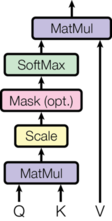

In [34]:
Image(filename =imagePath + "ModalNet-19.png")

In [0]:

### Calculating first the QK part with scaling
# queries shape == (S, B, I)
# values shape == (P + S, B, I)
# keys shape == (P + S, B, I)
# (calling J = P + S)
# This calculation here means multiplication along inner dimension I = 17

# NOTE: einsum not supported with named tensors
contentAttn: Tensor = torch.einsum('sbi, jbi -> sjb', [queries.rename(None), keys.rename(None)]) / (E ** 0.5)
# QK^T shape must be == (7, 13, 3) == (S, P + S, B)
assert contentAttn.shape == (S, P+S, B) == (7, 13, 3)
contentAttn: Tensor = contentAttn.refine_names('S', 'P_plus_S', 'B')

### Step 3: Relative Positional Encodings
Before applying softmax, we need [**relative positional encodings**](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1492622435/relative+positional+encoding+ml). Instead of having a single embedding represent each **absolute** position, the [Transformer XL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716) computes an embedding that represents the **relative** distance between any two tokens. This is called the [**relative positional embedding**](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1492622435/relative+positional+encoding+ml) and is used to compute the attention between the two word tokens.

In the [Transformer model](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1370095641/transformer+model+ml), the [attention score](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) between query $q_i$ and key vector $k_j$ within the same [segment embedding](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1511391715/segment+encoding+ml) can be decomposed as:
$$
\mathbf{A_{ij}}^\textbf{abs} = \underbrace{\mathbf{E_{x_i}}^T \mathbf{W_q}^T \mathbf{W_k} \mathbf{E_{x_j}}}_{(a)} + \underbrace{\mathbf{E_{x_i}}^T \mathbf{W_q}^T \mathbf{W_k} \mathbf{U_j}}_{(b)} + \underbrace{ \Big( \mathbf{U_i}^T \mathbf{W_q}^T \Big) \mathbf{W_k} \mathbf{E_{x_j}}}_{(c)} + \underbrace{ \Big( \mathbf{U_i}^T \mathbf{W_q}^T \Big) \mathbf{W_k} \mathbf{U_j}}_{(d)}
$$
where $E_x$ is the [word embedding](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/87666969/word+embedding+ml) for token $x$ and the $W$ are all transformation matrices.

But for the [Transformer XL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716) the terms are reparametrized as follows (to rely on relative positional information):
$$
\mathbf{A_{ij}}^\textbf{rel} = \underbrace{\mathbf{E_{x_i}}^T \mathbf{W_q}^T \mathbf{W_{k, E}} \mathbf{E_{x_j}}}_{(a)} + \underbrace{\mathbf{E_{x_i}}^T \mathbf{W_q}^T \mathbf{W_{k, R}} \color{cyan}{\mathbf{R_{i-j}}} }_{(b)} + \underbrace{ {\color{red}{\mathbf{u}^T}} \mathbf{W_{k, E}} \mathbf{E_{x_j}}}_{(c)} + \underbrace{ {\color{red}{\mathbf{v}^T}} \mathbf{W_{k,R}} \color{cyan}{\mathbf{R_{i-j}}} }_{(d)}
$$

**Describing the Changes:**

1. Replace all absolute positional embeddings $\mathbf{U_j}$ with the equivalent counterpart relative positional embedding $\color{cyan}{\mathbf{R_{i-j}}}$, since only relative distance matters in the attention calculation. NOTE: $\color{cyan}{\mathbf{R}}$ is a sinusoid encoding matrix without learnable parameters.
2. Introduce trainable parameter $\color{red}{u} \in \mathbb{R}^d$ to replace the query $\Big( \mathbf{U_i}^T \mathbf{W_q}^T \Big)$, just in term $(c)$. It was replaced because, in this case, since this query vector is the same for all query positions, the attentive bias towards different words should remain the same regardless of the query position. Similarly, a trainable parameter $\color{red}{v} \in \mathbb{R}^d$ substitutes the query term $\Big( \mathbf{U_i}^T \mathbf{W_q}^T \Big)$ in term $(d)$.
3. Separate the two weight matrices $\mathbf{W}_{k, E}$ and $\mathbf{W}_{k, R}$ for producing the content-based key vectors and location-based key vectors respectively.

**Describing Intuition Behind the Changes:**

Under this reparametrizing, every term has an intuitive meaning:
* **Content-based addressing:** is term $(a)$, represents the original attention score without any [positional encoding](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1470169419/positional+embedding+ml).
* **Content-dependent positional bias:** is term $(b)$, and is a positional bias with respect to the current query $Q_i$. It uses a sinusoidal function that gets *relative* distance between tokens (like $i - j$) instead of *absolute* position of a current token.
* **Learned global content bias:** is term $(c)$, is a learned vector that accounts for the other tokens in the key matrix $K$.
* **Learned global positional bias:** is term $(d)$, is a learned vector that adjusts the importance based only on distance between tokens, using the intuition that recent previous words are more relevant than words from previous paragraphs.

Implementing term $\large (c)$:

$$
\mathbf{A_{ij}}^\textbf{rel} = \underbrace{\mathbf{E_{x_i}}^T \mathbf{W_q}^T \mathbf{W_{k, E}} \mathbf{E_{x_j}}}_{(a)} + \underbrace{\mathbf{E_{x_i}}^T \mathbf{W_q}^T \mathbf{W_{k, R}} \color{cyan}{\mathbf{R_{i-j}}} }_{(b)} + {\Large \underbrace{ {\color{red}{\mathbf{u}^T}} \mathbf{W_{k, E}} \mathbf{E_{x_j}}}_{(c)}} + \underbrace{ {\color{red}{\mathbf{v}^T}} \mathbf{W_{k,R}} \color{cyan}{\mathbf{R_{i-j}}} }_{(d)}
$$

In [0]:
u: Tensor = torch.rand(I).expand_as(queries.rename(None)).refine_names('S', 'B', 'I')

assert u.shape == queries.shape == (S, B, I) == (7, 3, 17), "Test u.shape == queries.shape"

assert keys.shape == (P + S, B, I), "Test keys.shape"
assert keys.names == ('P_plus_S', 'B', 'I')

assert contentAttn.shape == (S, P+S, B) == (7, 13, 3), "Test content Attn shape before"
assert contentAttn.names == ('S', 'P_plus_S', 'B')

### Calculate term C, multiply along dimension I:    u x keys :     (S, B, I) x (P+S, B, I) ---> (S, P+S, B)
## GOAL: to get result after multiplying to have shape equal to contentAttn.shape which is 'sjb' so set the result shape to 'sjb' instead of other way 'jsb'
c: Tensor = torch.einsum('sbi, jbi -> sjb', [u.rename(None), keys.rename(None)])
c: Tensor = c.refine_names('S', 'P_plus_S', 'B')
contentAttn_C: Tensor = contentAttn + c / (E ** 0.5)

assert contentAttn_C.shape == (S, P+S, B), "Test content attention shape after adding term (c)"
assert contentAttn_C.names == ('S', 'P_plus_S', 'B')

Next: compute [relative positional embeddings](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1492622435/relative+positional+encoding+ml) necessary for the positional attention terms. For the the [relative positional embeddings](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1492622435/relative+positional+encoding+ml), the [Transformer XL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716) uses fixed sinusoidal embeddings.

In [0]:
posIndices: Tensor = torch.arange(S + P - 1, -1, -1.0, dtype = torch.float)
posIndices.names = ('P_plus_S',)

assert posIndices.shape == (P+S, ) == (13,)

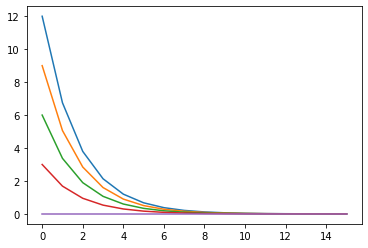

In [38]:
invFreq: Tensor = (1 / (10000 ** (torch.arange(0.0, E, 2.0) / E))).refine_names('E')# naming this dimension as E even though its size is currently E/2
assert invFreq.shape == (E/2,) == (16, )

# Outer Product to get sinusoidal tensor: This notation i, j -> ij means to keep both dimensions (cross product or outer product)
sinusoidInp: Tensor = torch.einsum('i, j -> ij', [posIndices.rename(None), invFreq.rename(None)])
sinusoidInp.names = ('P_plus_S', 'E') # need to do this manually ebcause einsum doesn'ts upport named tensors
assert sinusoidInp.shape == (P+S, E/2) == (13, 16)


# Plotting the sinusoidals on some dimensions:
plt.plot(sinusoidInp[0, :].detach().numpy());
plt.plot(sinusoidInp[3, :].detach().numpy());
plt.plot(sinusoidInp[6, :].detach().numpy());
plt.plot(sinusoidInp[9, :].detach().numpy());
plt.plot(sinusoidInp[12, :].detach().numpy());

In [0]:
# NOTE: dim = -1 means last dimension, so concatenating on last dimension here, only then adding tensor of dim 1 at dim 1
sinusoidInp_: Tensor = sinusoidInp.rename(None)
a = torch.cat([sinusoidInp_.sin(), sinusoidInp_.cos()], dim = -1)[:, None,:]
b = torch.cat([sinusoidInp_.sin(), sinusoidInp_.cos()], dim = -1).unsqueeze(1)
assert torch.equal(a, b), "Test another way of adding tensor of dim = 1 in a tensor"

# NOTE: Here torch.cat() works because we are concatenating along a dimension where names do not clash at all (at the last dimension, unnamed)
assert torch.cat([sinusoidInp.sin(), sinusoidInp.cos()], dim = -1).names == ('P_plus_S', 'E')

# Now can use align_to() to insert batch dimension B (with size 1) instead of using unsqueeze(1)
relPosEmbsTensor: Tensor = torch.cat([sinusoidInp.sin(), sinusoidInp.cos()], dim = -1).align_to('P_plus_S', 'B', 'E')
assert relPosEmbsTensor.names == ('P_plus_S', 'B', 'E')
assert relPosEmbsTensor.shape == b.shape == a.shape
# Check the view() is same as align_to()
assert torch.equal(relPosEmbsTensor.rename(None), b)

# B batch size = 1 now
assert relPosEmbsTensor.shape == (P+S, 1, E) == (13, 1, 32), "Test relative positional embeddings shape"

Gathering up all the above information into a class for [relative positional embeddings](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1492622435/relative+positional+encoding+ml):

In [0]:
from src.ModelStudy.TransformerXL.RelativePositionalEmbedding import RelativePositionalEmbedding

# Testing to see if this class if working:
rpe: RelativePositionalEmbedding = RelativePositionalEmbedding(embedDim= E)
#rpe

iPos: Tensor = torch.rand(P+S)
relPosEmbsTensor: Tensor = rpe(iPos)

assert relPosEmbsTensor.shape == (P+S, 1, E) == (13, 1, 32)
assert relPosEmbsTensor.names == ('P_plus_S', 'B', 'E')

Apply transformations to the [relative positional embeddings](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1492622435/relative+positional+encoding+ml) separate from the values and keys matrices, $V$ and $K$:

In [41]:
linearP: Linear = Linear(in_features = E, out_features = I)
linearP.weight.names = ('I', 'E')
linearP.bias.names = ('I',)

print(f"linearP: {linearP}")
printParamInfo(linearP)

linearP: Linear(in_features=32, out_features=17, bias=True)
Parameter 0 | Name = weight | Size = [('I', 17), ('E', 32)]
Parameter 1 | Name = bias | Size = [('I', 17)]


In [0]:
assert relPosEmbsTensor.names == ('P_plus_S', 'B', 'E')

# weightsLinearP x relPosEmbsTensor  ----> posEmbsTensor
# (I, E) x (P+S, B=1, E) ---> (P+S, B=1, I)
posEmbsTensor: Tensor = linearP(relPosEmbsTensor)

assert posEmbsTensor.names == ('P_plus_S', 'B', 'I')
assert relPosEmbsTensor.shape == (P+S, 1, E) == (13, 1, 32)
assert posEmbsTensor.shape == (P+S, 1, I) == (13, 1, 17)

Adding positional bias during attention computation:

In [0]:
# Positional bias (v)
v: Tensor = torch.randn(I).refine_names('I')

# The pos_tfmd just without the middle dimension
# NOTE: need to use squeeze() still, no replacement for this method like align_to() replaces view()
posEmbsTensor_squeezed: Tensor = posEmbsTensor.squeeze('B')
posEmbsTensor_view: Tensor = posEmbsTensor.rename(None).view(P+S, I)

assert (posEmbsTensor_view == posEmbsTensor_squeezed).all()

# WARNING!!! this is only true when the batch dimension B == 1
assert (posEmbsTensor[:, 0, :] == posEmbsTensor.squeeze('B')).all(), "Test alternate way of choosing first element of a dimension in a tensor"

assert posEmbsTensor_squeezed.names == ('P_plus_S', 'I')
assert posEmbsTensor_squeezed.shape == posEmbsTensor_view.shape == (P+S, I) == (13, 17)

### Calculate positional attention, multiplying along dimension I: (queries + v) x posNoMid
# (S, B, I) x (P+S, I) ---> (S, P+S, B)
# TODO: why not have: 'sbi, ji -> sbj' ??
queries_, v_, posEmbsTensor_ = queries.rename(None), v.rename(None), posEmbsTensor_squeezed.rename(None)
posAttn_: Tensor = torch.einsum('sbi, ji -> sjb', [queries_ + v_, posEmbsTensor_])
posAttn: Tensor = posAttn_.refine_names('S', 'P_plus_S', 'B')

assert posAttn.shape == (S, P+S, B) == (7, 13, 3)

Since we compute a [relative positional embedding](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1492622435/relative+positional+encoding+ml) for each key-query pair, a naive implementation of [attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) using [relative positional embedding](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1492622435/relative+positional+encoding+ml)s would be $O(n^2)$ in terms of computational complexity. Dai et al. (2019) can reduce this to $O(n)$ time by computing the [attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) for one query then shifting the [relative positional embedding](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1492622435/relative+positional+encoding+ml) for different query positions.

In [0]:
zeroPad_: Tensor = torch.zeros( (S, 1, B), dtype = torch.float)
zeroPad: Tensor = zeroPad_.refine_names('S', 'P_plus_S', 'B')

assert posAttn.names == ('S', 'P_plus_S', 'B')

assert posAttn_.shape == (S, P+S, B) == (7, 13, 3)
assert zeroPad_.shape == (S, 1, B) == (7, 1, 3)

assert torch.equal(zeroPad_, zeroPad.rename(None))
assert torch.equal(posAttn_, posAttn.rename(None))



# --------------------------------------------------------------------------------------------------------
# RELATIVE SHIFTING: This padding + shifting efficiently computes the attention for all
# Concatenate the zero pad with posAttn on dimension = 1 (works here for named tensors since dim = 1 has same name)
shift_: Tensor = torch.cat([zeroPad_, posAttn_], dim = 1) # unnamed shift
assert shift_.names == (None, None, None)
assert shift_.shape == (S, P+S+1, B) == (7, 14, 3)

shift: Tensor = torch.cat([zeroPad, posAttn], dim = 'P_plus_S') # named shift
assert shift.names == ('S', 'P_plus_S', 'B')
assert shift.shape == (S, P+S+1, B) == (7, 14, 3)

# Checking both shifts are equal:
assert torch.equal(shift_, shift.rename(None))


# --------------------------------------------------------------------------------------------------------
# Reshaping the shift_ with view() and named shift with align_as() to remove first element at P+S
shiftCut_: Tensor = shift_.view(P+S+1, S, B)[1:] # in relativeShift function : view(firstDim, secondDim, remainDims)[1:]
assert shiftCut_.shape == (P+S, S, B) == (13, 7, 3)
assert shiftCut_.names == (None, None, None)


shiftCut: Tensor = shift.align_to('P_plus_S', 'S', 'B')[1:] # align_to() is same as permute(), transpose()
assert shiftCut.shape == (P+S, S, B) == (13, 7, 3)
assert shift.names == ('S', 'P_plus_S', 'B')
assert shiftCut.names == ('P_plus_S', 'S', 'B') # dims 1, 2 have been switched around

### TODO LEFT OFF HERE TROUBLE
torch.equal(shiftCut_, shiftCut.rename(None))

# --------------------------------------------------------------------------------------------------------
# Last step: reshaping the SHIFT to be the same as posAttn shape

#posAttnPadded_: Tensor = (torch.cat([zeroPad_, posAttn_], dim = 1)
#                         .view(P+S+1, S, B)[1:] # switch dims to be P+S+1, S, and cut from dim=0 (P+S,S,B)
#                         .view_as(posAttn_)) # switching dims to be S, P+S (shape == (S, P+S, B)


#posAttnPadded: Tensor = (torch.cat([zeroPad, posAttn], dim = 'P_plus_S')
#                         .align_to('P_plus_S', 'S', 'B')[1:]
#                         .align_as(posAttn))


# Constructing the padded attention the unnamed way:
posAttnPadded_: Tensor = shiftCut_.view_as(posAttn_)
assert posAttnPadded_.shape == posAttn_.shape == (S, P+S, B) == (7, 13, 3)
assert posAttnPadded_.names == (None, None, None)

# Constructing the padded attention the NAMED way:
posAttnPadded: Tensor = shiftCut.align_as(posAttn)

assert posAttnPadded.names == posAttn.names == ('S', 'P_plus_S', 'B')
assert posAttnPadded.shape == posAttn.shape == (S, P+S, B) == (7, 13, 3)

The attention is computed as the **sum of the content and positional attention**:

In [0]:

rawAttn: Tensor = contentAttn_C + posAttnPadded

assert rawAttn.names == contentAttn_C.names == posAttnPadded.names == ('S', 'P_plus_S', 'B')
assert rawAttn.shape == contentAttn_C.shape == posAttnPadded.shape == (S, P+S, B) == (7, 13, 3)

When doing language modeling, we must prevent the model from 'cheating' (from looking at the word it should be predicting). In the [Transformer's decoder](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1521090937/decoder+self+attention+in+transformer), the [Transformer](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1370095641/transformer+model+ml) hides prediction words by setting the [attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1447035008/self+attention+mechanism) score to zero, to [mask](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1462730780/mask) out words the model should not see.

Adopting the same [attention masking in the `MultiHeadAttention` module](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1521090937/decoder+self+attention+in+transformer) for the [Transformer-XL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716/transformer-XL+model+ml):

In [46]:
# NOTE: triu concatenates upper triangular matrix, starting at upper row index = diagonal = 1+P = 8
torch.triu(torch.ones((S, P+S)), diagonal = 1+P ).byte()

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

In [0]:
longvec = torch.ones((S, P+S, S, P+S, S))
endDim: int = longvec.ndim
assert endDim == 5

resultUnsqueeze_ = torch.triu(longvec, diagonal = 1+P, ).byte().unsqueeze(endDim)
resultNone_ = torch.triu(longvec, diagonal = 1+P, ).byte()[...,None]
resultAlign = torch.triu(longvec, diagonal = 1+P, ).byte().align_to(..., 'END_DIM') # insert size 1 tensor at last dim
resultView_ = torch.triu(longvec, diagonal = 1+P, ).byte().view(*longvec.shape, 1)


assert resultUnsqueeze_.shape == resultNone_.shape == resultAlign.shape == resultView_.shape == (S, P+S, S, P+S, S, 1) == (7, 13, 7, 13, 7, 1)
assert resultUnsqueeze_.names == resultNone_.names == resultView_.names == (None, None, None, None, None, None)
assert resultAlign.names == (None, None, None, None, None, 'END_DIM')

# Checking: all combinations are equal: unsqueeze() == None method == align_to() == view() when inserting 1-dim tensors
resultAlign_ = resultAlign.rename(None)

assert (resultUnsqueeze_ == resultNone_).all()
assert (resultUnsqueeze_ == resultAlign_).all()
assert (resultUnsqueeze_ == resultView_).all()
assert (resultNone_ == resultAlign_).all()
assert (resultNone_ == resultView_).all()
# NOTE align_to() == view() because we added a dimension here, and were not permuting
assert (resultAlign_ == resultView_).all()

In [48]:
# Now applying the same strategy to the mask
mask_: Tensor = torch.triu(torch.ones((S, P+S)), diagonal = 1+P, ).byte().align_to(..., 'B')
# mask: Tensor = torch.triu(torch.ones((S, P+S)), diagonal = 1+P, ).byte().unsqueeze(2)
assert mask_.names == (None, None, 'B')

mask: Tensor = mask_.refine_names('S', 'P_plus_S', ...)
assert mask.names == ('S', 'P_plus_S', 'B')
assert mask.shape == (S, P+S, 1) == (7, 13, 1)

mask

tensor([[[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         [0],
         [0],
         [

In [0]:
# NOTE: changing mask to use type bool since mask with type byte is deprecated
maskBool = mask.bool()
rawAttnMasked: Tensor = rawAttn.masked_fill(mask = maskBool, value = -float('inf'))

assert maskBool.names == rawAttn.names == rawAttnMasked.names == ('S', 'P_plus_S', 'B')
assert rawAttn.shape == rawAttnMasked.shape == (S, P+S, B) == (7, 13, 3)
assert maskBool.shape == (S, P+S, 1)

Compute the outputs as the weighted sum of the value vectors in value matrix $V$, using the attention scores:

In [0]:
# Doing softmax on dim=1, which has size 13
attn: Tensor = torch.softmax(rawAttnMasked, dim = 'P_plus_S')

assert attn.names == rawAttnMasked.names == ('S', 'P_plus_S', 'B')
assert attn.shape == (S, P+S, B) == (7, 13, 3)

assert values.names == ('P_plus_S', 'B', 'I')
assert values.shape == (P + S, B, I) == (13, 3, 17)

# TODO: how to know which dimensions on which to do the calculations? Why is the shape 'sji' the one that is required?
# NOTE: doing calculation on dimension j = P+S so that result has shape SBI
attn_, values_ = attn.rename(None), values.rename(None)
attnWeightedSum: Tensor = torch.einsum('sjb, jbi -> sbi', [attn_, values_]).refine_names('S', 'B', 'I')

assert attnWeightedSum.shape == (S, B, I) == (7, 3, 17)
assert attnWeightedSum.names == ('S', 'B', 'I')

Final step: project the attention weighted sums back to their original dimension and apply a residual connection and layer normalization:

In [51]:

linearOut: Linear = Linear(in_features= I, out_features=E) # I = innerDim, E = embeddingDim
linearOut.weight.names = ('E', 'I')
linearOut.bias.names = ('E',)
print(linearOut)
printParamInfo(linearOut)

Linear(in_features=17, out_features=32, bias=True)
Parameter 0 | Name = weight | Size = [('E', 32), ('I', 17)]
Parameter 1 | Name = bias | Size = [('E', 32)]


In [52]:
layerNorm: LayerNorm = LayerNorm(normalized_shape= E) # E = embeddingDim
# WARNING: LayerNorm object  not supported with named tensors
# layerNorm.weight.names = ('E',)
# layerNorm.bias.names = ('E',)
print(layerNorm)
printParamInfo(layerNorm)

LayerNorm((32,), eps=1e-05, elementwise_affine=True)
Parameter 0 | Name = weight | Size = [(None, 32)]
Parameter 1 | Name = bias | Size = [(None, 32)]


In [0]:
assert wordEmbeddings.names == ('S', 'B', 'E')
assert attnWeightedSum.names == ('S', 'B', 'I')

assert wordEmbeddings.shape == (S, B, E) == (7, 3, 32)
assert attnWeightedSum.shape == (S, B, I) == (7, 3, 17)

# Weights x attnWeightedSum ----> linearOut   (multiplying along dimension I)
# (E, I) x (S, B, I) ----> (S, B, E)
assert linearOut(attnWeightedSum).shape == (S, B, E) == (7, 3, 32)
assert linearOut(attnWeightedSum).names == ('S', 'B', 'E')

# WARNING: LayerNorm object  not supported with named tensors
# weightsLayerNorm (E) * layerNormInput (S, B, E) ---> (S, B, E)
output_: Tensor = layerNorm((wordEmbeddings + linearOut(attnWeightedSum)).rename(None))
output: Tensor = output_.refine_names('S', 'B', 'E')

assert output.shape == (S, B, E) == (7, 3, 32)

### Step 4: MultiHeadAttention: The Core Component
Aggregating all the above and applying some optimizations by grouping computations and adding dropout, we can create the `MultiHeadAttention` module:

In [54]:
from src.ModelStudy.TransformerXL.MaskedMultiHeadAttention import MaskedMultiHeadAttention

# Mini-test to see if this class runs successfully:
H = 4
mha: MaskedMultiHeadAttention = MaskedMultiHeadAttention(embedDim= E,  # 32
                                                         innerDim = I,  # 17
                                                         numHeads = H,  # 4
                                                         dropoutO = 0.3)
mha

MaskedMultiHeadAttention(
  (linearKV): Linear(in_features=32, out_features=136, bias=False)
  (linearQ): Linear(in_features=32, out_features=68, bias=False)
  (linearP): Linear(in_features=32, out_features=68, bias=False)
  (dropoutA): Dropout(p=0.0, inplace=False)
  (linearOut): Linear(in_features=68, out_features=32, bias=False)
  (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropoutO): Dropout(p=0.3, inplace=False)
)

In [55]:
printParamInfo(mha) # so dropout is not a parameter

Parameter 0 | Name = linearKV.weight | Size = [('HI', 136), ('E', 32)]
Parameter 1 | Name = linearQ.weight | Size = [('HI', 68), ('E', 32)]
Parameter 2 | Name = linearP.weight | Size = [('HI', 68), ('E', 32)]
Parameter 3 | Name = linearOut.weight | Size = [('E', 32), ('HI', 68)]
Parameter 4 | Name = norm.weight | Size = [(None, 32)]
Parameter 5 | Name = norm.bias | Size = [(None, 32)]


In [0]:
torch.manual_seed(123)

inputWordEmbs: Tensor = torch.rand(S, B, E).refine_names('S', 'B', 'E')
# NOTE: putting in a batch dimension here even though the source tutorial doesn't, since otherwise error is thrown in
# the named tensor operation in MHA class at pos reshaping:
#     .flatten(dims = ['B', 'H'], out_dim = 'HB'))
# RuntimeError: Name 'B' not found in Tensor['P_plus_S', 'H', 'I'].
relPosEmbs: Tensor = torch.rand(P+S, B, E).refine_names('P_plus_S', 'B' , 'E')
memory: Tensor = torch.rand(P, B, E).refine_names('P', 'B', 'E')
u, v = torch.rand(H, I).refine_names('H', 'I'), torch.rand(H, I).refine_names('H', 'I')

outputMHA: Tensor = mha(inputWordEmbs, relPosEmbs, u, v, memory)

assert outputMHA.shape == (S, B, E) == (7, 3, 32)
assert outputMHA.names == ('S', 'B', 'E')

### Step 5: Positionwise Feed Forward Layer
After the [`MultiHeadAttention`](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1446445463/multi-head+attention+mechanism) layer is the [`PositionwiseFeedForward`](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/126190352/feed+forward+neural+network+FNN) layer. Both are the key components in the Decoder block.

In [57]:
from src.ModelStudy.TransformerXL.PositionwiseFeedForward import PositionwiseFeedForward


F = 71
# Testing the module:
posFF: PositionwiseFeedForward = PositionwiseFeedForward(embedDim = E, innerDim = F, dropoutO = 0.3)
posFF

PositionwiseFeedForward(
  (feedForward): Sequential(
    (0): Linear(in_features=32, out_features=71, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=71, out_features=32, bias=True)
    (4): Dropout(p=0.3, inplace=False)
  )
  (layerNorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
)

In [58]:
printParamInfo(posFF)

Parameter 0 | Name = feedForward.0.weight | Size = [('F', 71), ('E', 32)]
Parameter 1 | Name = feedForward.0.bias | Size = [('F', 71)]
Parameter 2 | Name = feedForward.3.weight | Size = [('E', 32), ('F', 71)]
Parameter 3 | Name = feedForward.3.bias | Size = [('E', 32)]
Parameter 4 | Name = layerNorm.weight | Size = [(None, 32)]
Parameter 5 | Name = layerNorm.bias | Size = [(None, 32)]


In [59]:
printChildInfo(posFF.feedForward) # all the items in Sequential() object

Child 0 | Name = 0 | Type = torch.nn.modules.linear.Linear
Child 1 | Name = 1 | Type = torch.nn.modules.activation.ReLU
Child 2 | Name = 2 | Type = torch.nn.modules.dropout.Dropout
Child 3 | Name = 3 | Type = torch.nn.modules.linear.Linear
Child 4 | Name = 4 | Type = torch.nn.modules.dropout.Dropout


In [60]:
briefParams(posFF)

{'feedForward.0.bias': (('F', 71),),
 'feedForward.0.weight': (('F', 71), ('E', 32)),
 'feedForward.3.bias': (('E', 32),),
 'feedForward.3.weight': (('E', 32), ('F', 71)),
 'layerNorm.bias': ((None, 32),),
 'layerNorm.weight': ((None, 32),)}

In [0]:
seqFF = posFF.feedForward

assert seqFF[0].weight.names == ('F', 'E')
assert seqFF[0].bias.names == ('F',)
assert seqFF[3].weight.names == ('E', 'F')
assert seqFF[3].bias.names == ('E',)

In [0]:
inputFF: Tensor = torch.rand(S, B, E).refine_names('S', 'B', 'E')

outputFF: Tensor = posFF(inputFF)

assert outputFF.shape == (S, B, E) == (7, 3, 32)
assert outputFF.names == ('S', 'B', 'E')

### Step 6: Build the Decoder
To construct the decoder block, all we need in addition to the [`MultiHeadAttention`](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1446445463/multi-head+attention+mechanism) layer is the [`PositionwiseFeedForward`](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/126190352/feed+forward+neural+network+FNN) layer.

**NOTE:** The [Transformer](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1370095641/transformer+model+ml)'s Encoder is SIMILAR to the [TransformerXL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716/transformer-XL+model+ml)'s Decoder. The [Transformer](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1370095641/transformer+model+ml)'s Encoder block uses un-masked [multi-head attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1446445463/multi-head+attention+mechanism) layer while the [TransformerXL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716/transformer-XL+model+ml) Decoder block uses [**masked** multi head attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1520894410/masked+multi-head+attention) layer. [TransformerXL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716/transformer-XL+model+ml)'s Decoder consists of the following components:

* A [masked multi-head attention](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1521090937/decoder+self+attention+in+transformer) block
* A simple [feedforward neural network](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/126190352/feed+forward+neural+network+FNN)

These components are connected using [residual connection](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1511358877/residual+connection+layer+ml)s and [layer normalization](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1450213381/layer+normalization)

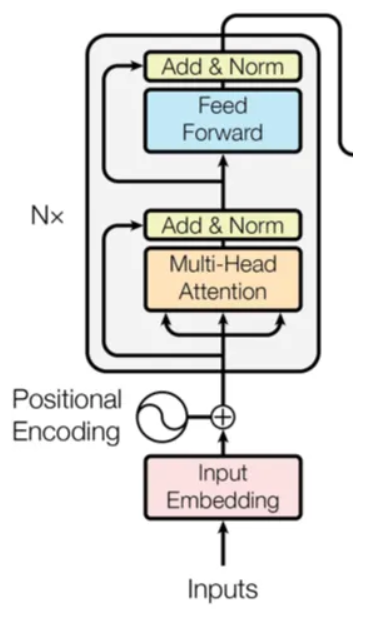

In [63]:
Image(filename = imagePath + "transformerEncoder_is_transXLDecoder.png")

In [0]:
from src.ModelStudy.TransformerXL.TransXLDecoderBlock import TransXLDecoderBlock


decoder: TransXLDecoderBlock = TransXLDecoderBlock(numHeads = H, embedDim = E, mhaInnerDim= I, ffInnerDim=F,
                                                   dropoutO = 0.3)

In [65]:
decoder

TransXLDecoderBlock(
  (maskedMultiHeadAttention): MaskedMultiHeadAttention(
    (linearKV): Linear(in_features=32, out_features=136, bias=False)
    (linearQ): Linear(in_features=32, out_features=68, bias=False)
    (linearP): Linear(in_features=32, out_features=68, bias=False)
    (dropoutA): Dropout(p=0.0, inplace=False)
    (linearOut): Linear(in_features=68, out_features=32, bias=False)
    (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (dropoutO): Dropout(p=0.3, inplace=False)
  )
  (poswiseFeedForward): PositionwiseFeedForward(
    (feedForward): Sequential(
      (0): Linear(in_features=32, out_features=71, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=71, out_features=32, bias=True)
      (4): Dropout(p=0.3, inplace=False)
    )
    (layerNorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
)

Testing that `mha` and `decoder.maskedMultiHeadAttention` are made of the same layers which have same parameter sizes and named dimensions.

In [66]:
assert isEqualStructure(mha, decoder.maskedMultiHeadAttention)
assert isEqualStructure(posFF, decoder.poswiseFeedForward)

briefParams(decoder)

{'maskedMultiHeadAttention.linearKV.weight': (('HI', 136), ('E', 32)),
 'maskedMultiHeadAttention.linearOut.weight': (('E', 32), ('HI', 68)),
 'maskedMultiHeadAttention.linearP.weight': (('HI', 68), ('E', 32)),
 'maskedMultiHeadAttention.linearQ.weight': (('HI', 68), ('E', 32)),
 'maskedMultiHeadAttention.norm.bias': ((None, 32),),
 'maskedMultiHeadAttention.norm.weight': ((None, 32),),
 'poswiseFeedForward.feedForward.0.bias': (('F', 71),),
 'poswiseFeedForward.feedForward.0.weight': (('F', 71), ('E', 32)),
 'poswiseFeedForward.feedForward.3.bias': (('E', 32),),
 'poswiseFeedForward.feedForward.3.weight': (('E', 32), ('F', 71)),
 'poswiseFeedForward.layerNorm.bias': ((None, 32),),
 'poswiseFeedForward.layerNorm.weight': ((None, 32),)}

In [67]:
briefParams(mha)

{'linearKV.weight': (('HI', 136), ('E', 32)),
 'linearOut.weight': (('E', 32), ('HI', 68)),
 'linearP.weight': (('HI', 68), ('E', 32)),
 'linearQ.weight': (('HI', 68), ('E', 32)),
 'norm.bias': ((None, 32),),
 'norm.weight': ((None, 32),)}

In [68]:
briefParams(posFF)

{'feedForward.0.bias': (('F', 71),),
 'feedForward.0.weight': (('F', 71), ('E', 32)),
 'feedForward.3.bias': (('E', 32),),
 'feedForward.3.weight': (('E', 32), ('F', 71)),
 'layerNorm.bias': ((None, 32),),
 'layerNorm.weight': ((None, 32),)}

In [0]:
# Setting seed to be same as for MHA example
torch.manual_seed(123)

inputWordEmbs: Tensor = torch.rand(S, B, E).refine_names('S', 'B', 'E')
# NOTE: like in above, putting here a batch dimension even though none in the original notebook test
relPosEmbs: Tensor = torch.rand(P+S, B, E).refine_names('P_plus_S', 'B','E')
memory: Tensor = torch.rand(P, B, E).refine_names('P', 'B', 'E')
u, v = torch.rand(H, I).refine_names('H', 'I'), torch.rand(H, I).refine_names('H', 'I')

outputDecoder: Tensor = decoder(inputWordEmbs, relPosEmbs, u, v, memory = memory)

assert outputDecoder.shape == (S, B, E) == (7, 3, 32)
assert outputDecoder.names == ('S', 'B', 'E')

# WARNING: this won't be true because the layers of each object have different initialization weights.
# assert (outputDecoder == posFF(mha(inputWordEmbs, relPosEmbs, u, v, memory))).all()

### Step 7: Full [TransformerXL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716/transformer-XL+model+ml)
Now will all these components we can build the full [Transformer XL model](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716/transformer-XL+model+ml).

#### [Weight-Tying](https://hyp.is/CFMUBm6eEeqnFUdyYjJC_Q/arxiv.org/pdf/1608.05859.pdf) Trick in [Language Modeling](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1474691325/language+model+ml):
A common trick on [language modeling](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1474691325/language+model+ml) is [weight tying, or tying the input embedding matrix $E$ and output projection matrix $P$](https://hyp.is/CFMUBm6eEeqnFUdyYjJC_Q/arxiv.org/pdf/1608.05859.pdf). Remember, a [language model](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1474691325/language+model+ml) predicts the next token in a sequence so its output dimension is $\mathbb{R}^{|V|}$ where $|V| =$ vocabulary size. If we constrain the penultimate layer output to be the same dimension as the [embeddings](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1474331193/embedding%2Bml) $d$, the [embedding](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1474331193/embedding%2Bml) matrix $E$ will have shape $\mathbb{R}^{|V| \times d}$ and the output projection matrix $P$ will have shape $\mathbb{R}^{d \times |V|}$.

#### Result of [Weight-Tying](https://hyp.is/CFMUBm6eEeqnFUdyYjJC_Q/arxiv.org/pdf/1608.05859.pdf):
Authors found [here]((https://hyp.is/iOhfhG6gEeqdJ5-92qbKvQ/arxiv.org/pdf/1608.05859.pdf)) that this [weight-tying](https://hyp.is/CFMUBm6eEeqnFUdyYjJC_Q/arxiv.org/pdf/1608.05859.pdf) by constraining the matrices such that $P = E^T$ improved performance while greatly reducing the total parameter count (and thus memory usage) of two of the three considered models.
* **NOTE 1:** For the [TransformerXL](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716/transformer-XL+model+ml) model, instead of using the exact same weights, we scale the [embeddings](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1474331193/embedding%2Bml) by the [embedding](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1474331193/embedding%2Bml) dimension.
* **NOTE 2:** this trick is included in the codebase but not mentioned in the paper. ($\color{red}{\texttt{Question: in the transformer xl paper??}}$)

In [0]:
from src.ModelStudy.TransformerXL.StandardWordEmbedding import StandardWordEmbedding

# Testing here how Embedding layer looks like and how it changes the dimension of the embedding matrix in order to accomplish weight-tying
N, E = 10, 32
swe: StandardWordEmbedding = StandardWordEmbedding(numEmbeddings=N, # N
                                                   embeddingDim = E)  # E
# WARNING: named tensors not supported in Embedding!
# swe.embedding.weight.names = ('N', 'E')

assert swe.embedding.weight.shape == (N, E)

In [71]:
briefParams(swe)

{'embedding.weight': ((None, 10), (None, 32))}

In [0]:
idx: torch.LongTensor = torch.LongTensor(torch.arange(S*B).reshape(S, B))
# swe(idx)

# TODO why does this give error????

### Step 8: Build [Transformer XL Model](https://synergo.atlassian.net/wiki/spaces/KnowRes/pages/1513586716/transformer-XL+model+ml)
Putting everything together:

In [73]:
# from src.ModelStudy.package.module import classname
from src.ModelStudy.TransformerXL.TransformerXL import TransformerXL


N = 1000
L = 4
M = 5 # memory length
H = 4

assert (S, P, B, E, I, F) == (7, 6, 3, 32, 17, 71)

transformerXL: TransformerXL = TransformerXL(numEmbeddings= N, numLayers=L, numHeads = H,
                                             modelDim = E, mhaInnerDim= I, ffInnerDim= F,
                                             memoryLen = M)
transformerXL

TransformerXL(
  (wordEmbeddingLayer): StandardWordEmbedding(
    (embedding): Embedding(1000, 32)
  )
  (relPosEmbeddingLayer): RelativePositionalEmbedding()
  (dropoutO): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): TransXLDecoderBlock(
      (maskedMultiHeadAttention): MaskedMultiHeadAttention(
        (linearKV): Linear(in_features=32, out_features=136, bias=False)
        (linearQ): Linear(in_features=32, out_features=68, bias=False)
        (linearP): Linear(in_features=32, out_features=68, bias=False)
        (dropoutA): Dropout(p=0.0, inplace=False)
        (linearOut): Linear(in_features=68, out_features=32, bias=False)
        (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropoutO): Dropout(p=0.1, inplace=False)
      )
      (poswiseFeedForward): PositionwiseFeedForward(
        (feedForward): Sequential(
          (0): Linear(in_features=32, out_features=71, bias=True)
          (1): ReLU(inplace=True)
          (2): Dropout(p=0.1, 

In [74]:

briefParams(transformerXL)

{'layers.0.maskedMultiHeadAttention.linearKV.weight': (('HI', 136), ('E', 32)),
 'layers.0.maskedMultiHeadAttention.linearOut.weight': (('E', 32), ('HI', 68)),
 'layers.0.maskedMultiHeadAttention.linearP.weight': (('HI', 68), ('E', 32)),
 'layers.0.maskedMultiHeadAttention.linearQ.weight': (('HI', 68), ('E', 32)),
 'layers.0.maskedMultiHeadAttention.norm.bias': ((None, 32),),
 'layers.0.maskedMultiHeadAttention.norm.weight': ((None, 32),),
 'layers.0.poswiseFeedForward.feedForward.0.bias': (('F', 71),),
 'layers.0.poswiseFeedForward.feedForward.0.weight': (('F', 71), ('E', 32)),
 'layers.0.poswiseFeedForward.feedForward.3.bias': (('E', 32),),
 'layers.0.poswiseFeedForward.feedForward.3.weight': (('E', 32), ('F', 71)),
 'layers.0.poswiseFeedForward.layerNorm.bias': ((None, 32),),
 'layers.0.poswiseFeedForward.layerNorm.weight': ((None, 32),),
 'layers.1.maskedMultiHeadAttention.linearKV.weight': (('HI', 136), ('E', 32)),
 'layers.1.maskedMultiHeadAttention.linearOut.weight': (('E', 32),

In [75]:
getUniqueModules(transformerXL) # show all modules at a glance, referred once, can even see which are hand-made classes by the __main__ prefix versus which moduels are from pytorch

{'CrossEntropyLoss': torch.nn.modules.loss.CrossEntropyLoss,
 'Dropout': torch.nn.modules.dropout.Dropout,
 'Embedding': torch.nn.modules.sparse.Embedding,
 'LayerNorm': torch.nn.modules.normalization.LayerNorm,
 'Linear': torch.nn.modules.linear.Linear,
 'MaskedMultiHeadAttention': src.ModelStudy.TransformerXL.MaskedMultiHeadAttention.MaskedMultiHeadAttention,
 'ModuleList': torch.nn.modules.container.ModuleList,
 'PositionwiseFeedForward': src.ModelStudy.TransformerXL.PositionwiseFeedForward.PositionwiseFeedForward,
 'ReLU': torch.nn.modules.activation.ReLU,
 'RelativePositionalEmbedding': src.ModelStudy.TransformerXL.RelativePositionalEmbedding.RelativePositionalEmbedding,
 'Sequential': torch.nn.modules.container.Sequential,
 'StandardWordEmbedding': src.ModelStudy.TransformerXL.StandardWordEmbedding.StandardWordEmbedding,
 'TransXLDecoderBlock': src.ModelStudy.TransformerXL.TransXLDecoderBlock.TransXLDecoderBlock,
 'TransformerXL': src.ModelStudy.TransformerXL.TransformerXL.Transf

In [76]:
# Getting some technicalities tested first:
a = torch.arange(start = P+S - 1, end = -1, step = -1, out = Tensor([-1.0]), dtype=torch.float)
b = torch.arange(start = P+S - 1, end = -1, step = -1, dtype=torch.float)

assert (a == b).all(), "Test that 'out' argument in 'torch.arange' makes no difference (note: it is also optional)."

/pytorch/aten/src/ATen/native/RangeFactories.cpp:170: UserWarning: The number of elements in the out tensor of shape [1] is 1 which does not match the computed number of elements 13. Note that this may occur as a result of rounding error. The out tensor will be resized to a tensor of shape (13,).


In [77]:
# Feeding random inputs to confirm model is working
indices: torch.LongTensor = torch.randint(N, (S, B)).refine_names('S', 'B')
targets: torch.LongTensor = torch.randint(N, (S, B)).refine_names('S', 'B')
# memory:

result: Dict[str, Tensor] = transformerXL(indices, targets)
resultLoss = list(result.values())[0]
resultLogits = list(result.values())[1]
resultMemoryList = list(result.values())[2]

assert resultLogits.shape == (S, B, N) and resultLogits.names == ('S', 'B', 'N')
assert [mem.shape == (M, B, E) and mem.names == ('M', 'B', 'E') for mem in resultMemoryList]

resultLoss

tensor(20.7609, grad_fn=<NllLossBackward>)